In [1]:
# 导入相关的库
import torch 
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
from torch.optim import SGD
import torch.utils.data as Data
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

In [2]:
# 使用手写字体数据，准备训练数据集
train_data=torchvision.datasets.MNIST(
    root="./data/MNIST" ,# 数据的路径
    train=True, # 只使用数据的训练数据集
    # 将数据转化为torch的使用张量，取值范围为【0,1】
    transform=torchvision.transforms.ToTensor(),
    download=False # 数据已经下载过，使用在这里不再下载
)
# 定义一个数据加载器
train_loader=Data.DataLoader(
    dataset=train_data,# 使用的数据集
    batch_size=128,# 批处理样本大小
    shuffle=True, # 每次迭代之前打乱数据
    num_workers=2,# 使用两个进程
)
 # 获取一个batch的数据
for step,(b_x,b_y) in enumerate(train_loader):
    if step>0:
        break
# 输出训练图像的尺寸和标签的尺寸
print("b_x.shape:",b_x.shape)
print("b_y.shape:",b_y.shape)

# 准备需要使用的测试机数据集
test_data=torchvision.datasets.MNIST(
    root="./data/MINST", # 数据的路径
    train=False ,# 不使用训练数据集
    download=False # 不下载数据集
)
# 为数据添加一个通道纬度，并且取值范围缩放到0-1之间
test_data_x=test_data.data.type(torch.FloatTensor)/255
test_data_x=torch.unsqueeze(test_data_x,dim=1)
test_data_y=test_data.targets # 测试集的标签
print("test_data_x.shape:",test_data_x.shape)
print("test_data_y.shape:",test_data_y.shape)

b_x.shape: torch.Size([128, 1, 28, 28])
b_y.shape: torch.Size([128])
test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


In [3]:
# 搭建一个卷积层神经网络
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        # 定义第一个卷积层
        self.convl=nn.Sequential(
            nn.Conv2d(
                in_channels=1, # 输入的feature map
                out_channels=16, # 输出的feature map
                kernel_size=3, # 卷积核的尺寸
                stride=1,# 卷积核的步长
                padding=1,# 进行一个填充
            ),
            nn.ReLU(),# 激活函数
            nn.AvgPool2d(
                kernel_size=2, # 平均池池化层，使用2*2
                stride=2, # 池化的步长为2
            ),
        )
        # 定义第二个卷积层
        self.conv2=nn.Sequential(
            nn.Conv2d(16,32,3,1,1),
            nn.ReLU(),# 激活函数
            nn.MaxPool2d(2,2)# 最大值池化
        )
        # 定义全连接层
        self.fc=nn.Sequential(
            nn.Linear(
                in_features=32*7*7, # 输入特征
                out_features=128,# 输出特征数
            ),
            nn.ReLU(),# 激活函数
            nn.Linear(128,64),
            nn.ReLU()# 激活函数
        )
        self.out=nn.Linear(64,10) # 最后的分类层
    # 定义网络的向前传播路径
    def forward(self,x):
        x=self.convl(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1)# 展现多为的卷积图层
        x=self.fc(x)
        output=self.out(x)
        return output

In [4]:
MyConvnet=ConvNet()
print(MyConvnet)

ConvNet(
  (convl): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [5]:
import hiddenlayer as hl
from graphviz import Digraph
# 可视化卷积层神经网络
hl_graph=hl.build_graph(MyConvnet,torch.zeros([1,1,28,28]))
hl_graph.theme=hl.graph.THEMES["blue"].copy()
# 将可视化的网络保存为图片
hl_graph.save("data/chap4/MyConvnet_hl.png",format="png")


In [6]:
from torchviz import make_dot
# 使用make——dot可视化网络
x=torch.randn(1,1,28,28).requires_grad_(True)
y=MyConvnet(x)
MyConvnetvis=make_dot(y,params=dict(list(MyConvnet.named_parameters())+[('x',x)]))
# 将MyConvnetvis保存为图片
MyConvnetvis.format="png"
# 指定文件保存位置
MyConvnetvis.directory="data/chap4/MyConvnet_vis"
MyConvnetvis.view()
# 会自动生成当前文件夹生成文件



'data/chap4/MyConvnet_vis\\Digraph.gv.png'

In [7]:
# 从tensorboardX库中导入需要的API
from tensorboardX import SummaryWriter
import torch.nn as nn
import torch
SumWriter=SummaryWriter(log_dir="data/chap4/log")
# 定义一个优化器
optimizer=torch.optim.Adam(MyConvnet.parameters(),lr=0.0003)
loss_func=nn.CrossEntropyLoss() # 损失函数
train_loss=0
print_step=100 # 经过一百次迭代之后，输出损失
# 对模型进行迭代训练，对所有的数据训练EPOCH轮
for epoch in range(5):
    # 对训练数据的加载器进行迭代计算
    for step,(b_x,b_y) in enumerate(train_loader):
        # 计算每个batch的损失
        output=MyConvnet(b_x)# CNN在训练batch上的输出
        loss=loss_func(output,b_y)# 交叉熵损失函数
        optimizer.zero_grad()# 每一个迭代步有的梯度初始化为0
        loss.backward() # 损失的后向传播，计算梯度
        optimizer.step() # 利用梯度进行优化
        train_loss=train_loss+loss # 计算损失的累加损失
        # 计算迭代次数
        niter=epoch*len(train_loader)+step+1
        # 计算每经过print_step 此迭代后的输出
        if niter%print_step==0:
            # 为日志添加训练集损失函数
            SumWriter.add_scalar("train_loss",train_loss.item()/niter,global_step=niter)
            # 计算在测试集上的精度
            output=MyConvnet(test_data_x)
            _,pre_lab=torch.max(output,1)
            acc=accuracy_score(test_data_y,pre_lab)
            # 为日志添加在测试集上的预测精度
            SumWriter.add_scalar("test acc",acc.item(),niter)
            # 为日志中添加训练数据的可视化图像，使用当前batch的图像
            # 将一个batch的数据进行预处理
            b_x_im=vutils.make_grid(b_x,nrow=12)
            SumWriter.add_image('train image sample',b_x_im,niter)
            # 使用直方图可视化网络中参数的分布情况
            for name,param in MyConvnet.named_parameters():
                SumWriter.add_histogram(name,param.data.numpy(),niter)



        



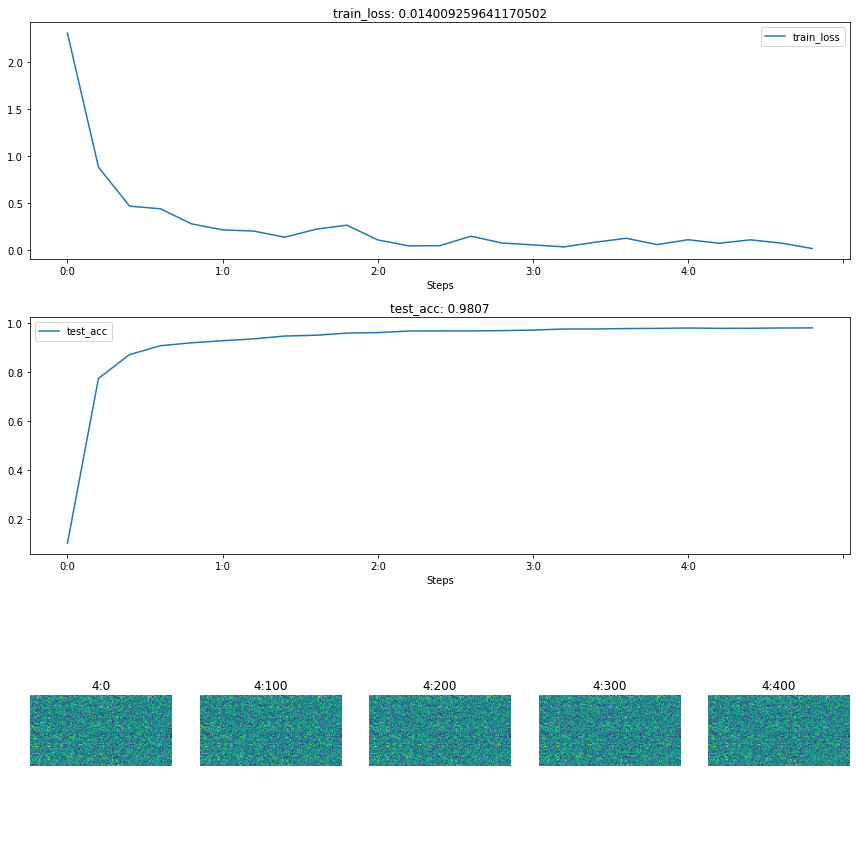

In [12]:
import hiddenlayer as hl
import time
# 初始化MyConvnet
MyConvnet=ConvNet()
# 定义优化器
optimizer=torch.optim.Adam(MyConvnet.parameters(),lr=0.0003)
loss_func=nn.CrossEntropyLoss() # 损失函数
# 记录训练过程的指标
history1=hl.History()
# 使用Canvas进行可视化
canvas1=hl.Canvas()
print_step=100 # 每次经过一百次迭代之后，输出损失
# 对模型进行迭代训练，对所有数据训练epoch轮
for epoch in range(5):
    # 对训练数据的加载器进行迭代计算
    for step,(b_x,b_y) in enumerate(train_loader):
        # 计算每一个batch的损失
        output=MyConvnet(b_x) # CNN在训练batch上的输出
        loss=loss_func(output,b_y)# 交叉熵损失函数
        optimizer.zero_grad()# 每一个迭代不1梯度初始化为0
        loss.backward()# 巡视的后向传播，计算梯度
        optimizer.step() # 使用梯度进行优化
        # 计算迭代次数
        # 计算每次经过print_step此次迭代后的输出
        if step% print_step==0:
            # 计算在测试集上的精度
            output=MyConvnet(test_data_x)
            _,pre_lab=torch.max(output,1)
            acc=accuracy_score(test_data_y,pre_lab)
            # 计算第一个epoch和step的模型的输出特征
            history1.log((epoch,step),
            train_loss=loss,# 训练集损失
            test_acc=acc, # 训练集精度
            #计算第二个全连接层权重
            hidden_weight=MyConvnet.fc[2].weight)
            # 可视化网络训练的过程
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_acc"])
                canvas1.draw_image(history1["hidden_weight"])

        